In [ ]:
# !git clone "https://github.com/dylan-slack/Fooling-LIME-SHAP"

fatal: destination path 'Fooling-LIME-SHAP' already exists and is not an empty directory.


In [29]:
from packaging import version

In [1]:
%%script --false

## Installing dependencies
!pip install lime --quiet
!pip install shap --quiet
!pip install gensim --quiet

## installing runtime restart required packages
import matplotlib as mlp
if version.parse(mlp.__version__) < version.parse('3.5'):
  !pip install matplotlib==3.5 --quiet
  print('Stopping RUNTIME! Please run again.')
  # import os
  # os.kill(os.getpid(), 9)
  exit()


Couldn't find program: '--false'


### Libraries

In [2]:
# importing required libraries
import numpy as np
import pandas as pd
import os
from os import path
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from datetime import datetime as dt

In [32]:
data_path = os.path.join(os.getcwd(), "data")
generated_data_path = os.path.join(data_path, "generated_data")

### Loading Dataset

# Fooling LIME and SHAP

## utils

In [33]:
import json
import re
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, OrdinalEncoder,LabelEncoder, \
                                    MinMaxScaler, OneHotEncoder, LabelBinarizer
class Params():
    """Parameters object taken from: https://github.com/cs230-stanford/cs230-code-examples/blob/master/pytorch/nlp/utils.py

    Parameters
    ----------
    json_path : string

    Returns
    ----------
    Parameters object
    """
    def __init__(self, json_path):
        with open(json_path) as f:
            params = json.load(f)
            self.__dict__.update(params)

    def save(self, json_path):
        with open(json_path, 'w') as f:
            json.dump(self.__dict__, f, indent=4)

    def update(self, json_path):
        """Loads parameters from json file"""
        with open(json_path) as f:
            params = json.load(f)
            self.__dict__.update(params)

    @property
    def dict(self):
        """Gives dict-like access to Params instance by `params.dict['learning_rate']"""
        return self.__dict__


def one_hot_encode(y):
    """ One hot encode y for binary features.  We use this to get from 1 dim ys to predict proba's.
    This is taken from this s.o. post: https://stackoverflow.com/questions/29831489/convert-array-of-indices-to-1-hot-encoded-numpy-array

    Parameters
    ----------
    y : np.ndarray

    Returns
    ----------
    A np.ndarray of the one hot encoded data.
    """
    y_hat_one_hot = np.zeros((len(y), 2))
    y_hat_one_hot[np.arange(len(y)), y] = 1
    return y_hat_one_hot

def rank_features(explanation):
    """ Given an explanation of type (name, value) provide the ranked list of
    feature names according to importance

    Parameters
    ----------
    explanation : list

    Returns
    ----------
    List containing ranked feature names
    """
    # Reorder the list of tuples according to the value of importance
    ordered_tuples = sorted(explanation, key=lambda x : abs(x[1]), reverse=True)
    # Features without importance are renamed as 'Zero importance'
    results = [re.split("[=><]+",  tup[0])[0] if tup[1] != 0 else ("Zero importance",0) for tup in ordered_tuples]
    return results

def get_rank_map(ranks, to_consider):
    """ Give a list of feature names in their ranked positions, return a map
    from position ranks to pct occurances.

    Parameters
    ----------
    ranks : list
    to_consider : int

    Returns
    ----------
    A dictionary containing the ranks mapped to the uniques.
    """
    unique = {i+1 : [] for i in range(len(ranks))}

    for i, rank in enumerate(ranks):
      # Also the unique values are reversed to get the highest
      # appearing feature at start
      # rank is the list of occurences for each position (e.g. 1,2,3)
      for unique_rank in np.unique(rank):
        unique[i+1].append((unique_rank, np.sum(np.array(rank) ==
                                        unique_rank) / to_consider))
    # sort the list of occurences in the dictionary
    unique = {i+1: sorted(unique[i+1], key=lambda tup: (-tup[1], tup[0])) for i in range(len(unique))}
    return unique

def experiment_summary(explanations, features):
    """ Provide a high level display of the experiment results for the top three features.
    This should be read as the rank (e.g. 1 means most important) and the pct occurances
    of the features of interest.

    Parameters
    ----------
    explanations : list
    explain_features : list
    bias_feature : string  ????TTS

    Returns
    ----------
    A summary of the experiment
    """
    # features_of_interest = explain_features + [bias_feature]
    top_features = [[], [], []]
    # 'explanations' is a list of list of tuples
    # sort ranks into top 3 features
    if isinstance(features, pd.Index):
        features = features.to_list()
        features.append("Zero importance")
    elif isinstance(features, list):
        features.append("Zero importance")
    for exp in explanations:
        ranks = rank_features(exp)    # ranks = one datapoint's exp; ordered list of feature names
        for i in range(3):
            for f in features:
                if f in ranks[i]:
                    top_features[i].append(f)
    return get_rank_map(top_features, len(explanations))


def standardization(df, col):
  std_scaler = StandardScaler()
  for i in col:
    arr = df[i]
    arr = np.array(arr)
    df[i] = std_scaler.fit_transform(arr.reshape(len(arr),1))
  return df


def plot_lime(lime_one_ft, scaler):
  fl = [lime_one_ft[key][0] for key, val in lime_one_ft.items()]
  fo = [lime_one_ft[key][0] for key, val in lime_one_ft.items()]
  fo_labels = ['other'] * 3
  fl_labels = [tup[0] for tup in fl]
  fl_vals = [tup[1] for tup in fl]
  fo_vals = [1 - val for val in fl_vals]

  labels = ["Rank "+str(val) for val in list(lime_one_ft.keys()) ]

  width = 0.4

  fig, ax = plt.subplots()

  ax.bar(labels, fl_vals, width, label='Feature')
  ax.bar(labels, fo_vals, width, bottom=fl_vals, label='other')

  for i in range(len(labels)):
    if fl_vals[i] > 0.5 and len(fl_labels[i])>7:
      plt.text(i,0.1, fl_labels[i], ha = 'center', rotation=90,
                  bbox = dict(facecolor = 'cyan', alpha =0.5))
    elif fl_vals[i] > 0.5:
      plt.text(i,fl_vals[i]-0.5, fl_labels[i], ha = 'center', rotation=90,
                  bbox = dict(facecolor = 'cyan', alpha =0.5))
    if fl_vals[i] < 0.5:
      plt.text(i,fl_vals[i],fl_labels[i], ha = 'center', rotation=90,
                  bbox = dict(facecolor = 'cyan', alpha =0.5))

  ax.set_ylabel('Occurences as a percentage')
  ax.set_title('Occurences of each feature per rank with the '+scaler)
  # ax.legend()
  ax.legend(ncol=1, bbox_to_anchor=(1, 0), loc='lower left', fontsize='small')
  plt.show()


## get_data NIDD5G dataset

In [34]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

class NIDD5G_data():
  """ Handle preprocessing and ouput a usable dataframe. Drops unnecessary columns,
  seperate continuous and categorical columns.

  Parameters
  ----------
  data_path (str) : Base path for the dataset folder

  Returns
  ----------
  None
  """
  def __init__(self, data_path):
    # path to the dataset
    self.DATA_PATH = os.path.join(data_path, "5GNIDD", "Encoded.csv")

    # (TBD) Multiclass classification labels
    self.MULTICLASS_ATTACK_COLUMNS= ['Attack Tool', 'Attack Type']

    # Define the labels for binary classification
    self.NORMAL = 0
    self.ATTACK = 1

    self.full_X, self.full_y = self.read_nslkdd_dataset(self.DATA_PATH)

  # Read both train and test data files ad concatenate into one dataframe
  def read_nslkdd_dataset(self, data_path):
    df = pd.read_csv(data_path)
    # Do some initial preprocessing
    df = df.iloc[:, 1:]
    df.drop(self.MULTICLASS_ATTACK_COLUMNS, axis=1, inplace=True)
    df.reset_index(drop=True, inplace=True)
    labels = df.pop('Label')
    # Feature names before dropping NAN columns
    self.RAW_FEATURES = df.columns.to_list()
    return df, labels
  
  def remove_nan_cols(self, df):
    # Collect information about the NAN columns
    df_datatypes = pd.DataFrame(df.dtypes)
    df_null_count = df.count()
    self.df_nan_info = pd.concat([df_datatypes, df_null_count], axis=1)
    self.df_nan_info.columns = range(len(self.df_nan_info.columns))
    self.df_nan_info.rename(columns={0: 'Data Type', 1: 'Null Count'}, inplace=True)
    self.df_nan_info['Null %'] = self.df_nan_info['Null Count'] \
                                      / self.df_nan_info.shape[0] * 100
    self.df_nan_info = self.df_nan_info[self.df_nan_info['Null %']<100]
    # Drop NAN columns
    df = df.dropna(axis=1).reset_index(drop=True)
    return df

  def _categorize_cols(self, df):
    # Binary numeric column names
    #['land','logged_in','root_shell', 'su_attempted','is_host_login','is_guest_login']
    self.BINARY_COLS = self.get_binary_cols(df)
    self.CONT_COLS = [x for x in df.columns.to_list() if x not in self.BINARY_COLS]
    return None

  def get_binary_cols(self, df):
    df = df.loc[:, df.nunique(axis=0)<=2]
    return df.columns.to_list()

  def get_sampled_data(self, sample_size=None, split_ratio=None, random_state=48):
    if split_ratio is not None:
      df_sampled = self.FULL_DF.sample(n=sample_size, random_state=random_state)
      bin_label = df_sampled.pop('Label')
      self.FEATURES = df_sampled.columns
      self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(df_sampled
                          , bin_label
                          , test_size=split_ratio
                          , random_state=40
                          , stratify=bin_label)
      return self.X_train, self.X_test, self.y_train, self.y_test
    else:
      self.SAMPLED_DF = self.FULL_DF.sample(n=sample_size)
      self.FEATURES = self.SAMPLED_DF.columns
      return self.SAMPLED_DF

  def scale_data(self, DataFrame):
    # Scaling the continuous columns
    self.ct = ColumnTransformer([('scaler', StandardScaler(), self.CONT_COLS)]
                          , remainder='passthrough'
                          , verbose_feature_names_out=False)
    scaled_df = pd.DataFrame(self.ct.fit_transform(DataFrame),
                              columns=self.ct.get_feature_names_out())
    return scaled_df

  def preprocess_data(self, sample=None, split_ratio=0.25):
    """
    Handle preprocessing and ouput a usable dataframe. Drops unnecessary columns,
    seperate continuous and categorical columns.

    Parameters
    ----------
        classification : str
            Type of inference whether it is 'binary' or 'multi-class'
        split_ratio : float
            Train, test data split ratio
    Returns
    -------
        X_train (df): Training samples
        y_train (df): Training labels
        X_test (df):  Testing samples
        y_test (df): Testing labels
    """
    if self.full_X is not None:
      df = self.full_X
    else:
      print("Dataset is not read properly")

    # adjusting the label column
    bin_label = pd.DataFrame(self.full_y.map(
        lambda x:self.NORMAL if x=='Benign' else self.ATTACK), columns=['Label'])
    
    # Remove NAN columns
    df = self.remove_nan_cols(df)

    # Save column details
    self._categorize_cols(df)

    df = self.scale_data(df)

    # Save the full dataframe and labels
    self.FULL_DF = pd.concat([df, bin_label], axis=1)

    if sample is not None:
      df = self.FULL_DF.sample(n=sample)
      bin_label = df.pop('Label')
      self.SAMPLED_DF = df

    self.FEATURES = df.columns

    # Putting to canonical terms
    self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(df, bin_label
                                          , test_size=split_ratio
                                          , random_state=40
                                          , stratify=bin_label)
    return self.X_train, self.X_test, self.y_train, self.y_test

nidd5g_data = NIDD5G_data(data_path)
X_train, X_test, y_train, y_test = nidd5g_data.preprocess_data(split_ratio=0.20
                                                    , sample=20000)


## adversarial_models

In [35]:
import numpy as np
import pandas as pd

import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

from copy import deepcopy

import shap

class Adversarial_Model(object):
  """  A scikit-learn style adversarial explainer base class for adversarial models.  This accetps
  a scikit learn style function f_obscure that serves as the _true classification rule_ for in distribution
  data.  Also, it accepts, psi_display: the classification rule you wish to display by explainers (e.g. LIME/SHAP).
  Ideally, f_obscure will classify individual instances but psi_display will be shown by the explainer.

  Parameters
  ----------
  f_obscure : function
  psi_display : function
  """
  def __init__(self, f_obscure, psi_display):
    self.f_obscure = f_obscure
    self.psi_display = psi_display

    self.cols = None
    self.scaler = None
    self.numerical_cols = None

  def predict_proba(self, X, threshold=0.5):
    """ Scikit-learn style probability prediction for the adversarial model.

    Parameters
    ----------
    X : np.ndarray

    Returns
    ----------
    A numpy array of the class probability predictions of the advesarial model.
    """
    if self.perturbation_identifier is None:
      raise NameError("Model is not trained yet, can't perform predictions.")

    # generate the "true" predictions on the data using the "bad" model -- this is f in the paper
    predictions_to_obscure = self.f_obscure.predict_proba(X)

    # generate the "explain" predictions -- this is psi in the paper

    predictions_to_explain_by = self.psi_display.predict_proba(X)

    # in the case that we're only considering numerical columns
    if self.numerical_cols:
      X = X[:,self.numerical_cols]

    # allow thresholding for finetuned control over psi_display and f_obscure
    pred_probs = self.perturbation_identifier.predict_proba(X)
    perturbation_preds = (pred_probs[:,1] >= threshold)

    sol = np.where(np.array([perturbation_preds == 1, perturbation_preds==1]).transpose()
                  , predictions_to_obscure
                  , predictions_to_explain_by)

    return sol

  def predict(self, X):
    """  Scikit-learn style prediction. Follows from predict_proba.

    Parameters
    ----------
    X : np.ndarray

    Returns
    ----------
    A numpy array containing the binary class predictions.
    """
    pred_probs = self.predict_proba(X)
    return np.argmax(pred_probs,axis=1)

  def score(self, X_test, y_test):
    """ Scikit-learn style accuracy scoring.

    Parameters:
    ----------
    X_test : X_test
    y_test : y_test

    Returns:
    ----------
    A scalar value of the accuracy score on the task.
    """

    return np.sum(self.predict(X_test)==y_test) / y_test.size

  def get_column_names(self):
    """ Access column names."""

    if self.cols is None:
      raise NameError("Train model with pandas data frame to get column names.")

    return self.cols

  def fidelity(self, X):
    """ Get the fidelity of the adversarial model to the original predictions.
    High fidelity means that we're predicting f along the in distribution data.

    Parameters:
    ----------
    X : np.ndarray

    Returns:
    ----------
    The fidelity score of the adversarial model's predictions to the model you're trying to obscure's predictions.
    """

    return (np.sum(self.predict(X) == self.f_obscure.predict(X)) / X.shape[0])

class Adversarial_Lime_Model(Adversarial_Model):
  """ Lime adversarial model. Generates an adversarial model for LIME style
  explainers using the Adversarial Model base class.

  Parameters:
  ----------
  f_obscure : function
  psi_display : function
  perturbation_std : float
  """
  def __init__(self, f_obscure, psi_display, perturbation_std=0.3):
    super(Adversarial_Lime_Model, self).__init__(f_obscure, psi_display)
    # psi_display is added as an instance variable only for analysis
    self.psi_display = psi_display
    self.perturbation_std = perturbation_std

  def train(self, X, y, feature_names, perturbation_multiplier=30,
            categorical_features=[], rf_estimators=100, estimator=None):
    """ Trains the adversarial LIME model.  This method trains the perturbation
    detection classifier to detect instances that are either in the manifold or
    not if no estimator is provided.

    Parameters:
    ----------
    X : np.ndarray of pd.DataFrame
    y : np.ndarray
    perturbation_multiplier : int
    cols : list
    categorical_columns : list
    rf_estimators : integer
    estimaor : func
    """
    print ('---------------------')
    print ("Adversarial LIME model training....")
    print ('---------------------')

    if isinstance(X, pd.DataFrame):
      cols = [c for c in X]
      X = X.values
    elif not isinstance(X, np.ndarray):
      raise NameError("X of type {} is not accepted. Only pandas dataframes or \
      numpy arrays allowed".format(type(X)))

    self.cols = feature_names
    all_x, all_y = [], []

    # loop over perturbation data to create larger data set
    for _ in range(perturbation_multiplier):
      perturbed_xtrain = np.random.normal(0,self.perturbation_std,size=X.shape)
      p_train_x = np.vstack((X, X + perturbed_xtrain))
      p_train_y = np.concatenate((np.ones(X.shape[0]), np.zeros(X.shape[0])))

      all_x.append(p_train_x)
      all_y.append(p_train_y)

    all_x = np.vstack(all_x)
    all_y = np.concatenate(all_y)

    # it's easier to just work with numerical columns, so focus on them for
    # exploiting LIME
    self.numerical_cols = [feature_names.index(c) for c in feature_names if
                           feature_names.index(c) not in categorical_features]

    if self.numerical_cols == []:
      raise NotImplementedError("We currently only support numerical column data. \
      If your data set is all categorical, consider using SHAP adversarial model.")

    # generate perturbation detection model as RF
    xtrain = all_x[:,self.numerical_cols]
    xtrain, xtest, ytrain, ytest = train_test_split(xtrain, all_y, test_size=0.2)

    if estimator is not None:
      self.perturbation_identifier = estimator.fit(xtrain, ytrain)
    else:
      self.perturbation_identifier = RandomForestClassifier(
          n_estimators=rf_estimators).fit(xtrain, ytrain)

    ypred = self.perturbation_identifier.predict(xtest)
    self.ood_training_task_ability = (ytest, ypred)

    return self

class Adversarial_Kernel_SHAP_Model(Adversarial_Model):
  """ SHAP adversarial model.  Generates an adversarial model for SHAP style
  perturbations.

  Parameters:
  ----------
  f_obscure : function
  psi_display : function
  """
  def __init__(self, f_obscure, psi_display):
    super(Adversarial_Kernel_SHAP_Model, self).__init__(f_obscure, psi_display)

  def train(self, X, y, feature_names, background_distribution=None,
            perturbation_multiplier=10, n_samples=2e4, rf_estimators=100,
            n_kmeans=10, estimator=None):
    """ Trains the adversarial SHAP model. This method perturbs the shap training
    distribution by sampling from its kmeans and randomly adding features.
    These points get substituted into a test set.  We also check to make sure that
    the instance isn't in the test set before adding it to the out of distribution
    set. If an estimator is
    provided this is used.

    Parameters:
    ----------
    X : np.ndarray
    y : np.ndarray
    features_names : list
    perturbation_multiplier : int
    n_samples : int or float
    rf_estimators : int
    n_kmeans : int
    estimator : func

    Returns:
    ----------
    The model itself.
    """
    print ('---------------------')
    print ("Adversarial SHAP model training....")
    print ('---------------------')

    if isinstance(X, pd.DataFrame):
      X = X.values
    elif not isinstance(X, np.ndarray):
      raise NameError("X of type {} is not accepted. Only pandas dataframes or numpy arrays allowed".format(type(X)))

    self.cols = feature_names

    # This is the mock background distribution we'll pull from to create substitutions
    if background_distribution is None:
      background_distribution = shap.kmeans(X,n_kmeans).data
    repeated_X = np.repeat(X, perturbation_multiplier, axis=0)

    new_instances = []
    equal = []

    # We generate n_samples number of substutions
    for _ in range(int(n_samples)):
      i = np.random.choice(X.shape[0])
      point = deepcopy(X[i, :])

      # iterate over points, sampling and updating
      for _ in range(X.shape[1]):
        j = np.random.choice(X.shape[1])
        point[j] = deepcopy(background_distribution[np.random.choice(
            background_distribution.shape[0]),j])

      new_instances.append(point)

    substituted_training_data = np.vstack(new_instances)
    all_instances_x = np.vstack((repeated_X, substituted_training_data))

    # make sure feature truly is out of distribution before labeling it
    xlist = X.tolist()
    ys = np.array([1 if substituted_training_data[val,:].tolist() in xlist else 0\
             for val in range(substituted_training_data.shape[0])])

    all_instances_y = np.concatenate((np.ones(repeated_X.shape[0]),ys))

    xtrain,xtest,ytrain,ytest = train_test_split(all_instances_x,
                                                 all_instances_y, test_size=0.2)

    if estimator is not None:
      self.perturbation_identifier = estimator.fit(xtrain,ytrain)
    else:
      self.perturbation_identifier = RandomForestClassifier(n_estimators=rf_estimators).fit(xtrain,ytrain)

    ypred = self.perturbation_identifier.predict(xtest)
    self.ood_training_task_ability = (ytest, ypred)

    return self


## Experiment Setup

In [36]:
from sklearn.utils import estimator_html_repr
"""
The experiment MAIN for NSLKDD dataset with LIME.

"""
import warnings

# from adversarial_models import *
# from utils import *
# from get_data import *

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, minmax_scale, MaxAbsScaler, \
                                  StandardScaler, RobustScaler, Normalizer, \
                                  QuantileTransformer, PowerTransformer
import numpy as np
import pandas as pd

import lime
import lime.lime_tabular
import shap

from copy import deepcopy

###
## The models f and psi for NSLKDD.  We discriminate based on race for f and concider
#  two RANDOMLY DRAWN features to display in psi
#


# the biased model
class racist_model_f:
    # Decision rule: classify negatively if race is black
  def __init__(self, race_indc):
    self.race_indc = race_indc

  def predict(self,X):
    return np.array([params.negative_outcome
                      if x[self.race_indc] > 0 else params.positive_outcome for x in X])

  def predict_proba(self, X):
    return one_hot_encode(self.predict(X))

  def score(self, X,y):
    return np.sum(self.predict(X)==y) / len(X)

# the display model with one unrelated feature
class innocuous_model_psi:

  def __init__(self, unrelated_indcs, unrelated_indcs1):
    self.unrelated_indcs = unrelated_indcs
    self.unrelated_indcs1 = unrelated_indcs1

  # Decision rule: classify according to randomly drawn column 'unrelated column'
  def predict_proba(self, X):
    return one_hot_encode(np.array([params.negative_outcome
                                    if x[self.unrelated_indcs] > 0 else params.positive_outcome
                                    for x in X]))

# the display model with two unrelated features
class innocuous_model_psi_two:
  def predict_proba(self, X):
    A = np.where(X[:,self.unrelated_indcs] > 0, params.positive_outcome, params.negative_outcome)
    B = np.where(X[:,self.unrelated_indcs1] > 0, params.positive_outcome, params.negative_outcome)
    preds = np.logical_xor(A, B).astype(int)
    return one_hot_encode(preds)

class innocuous_model_alpha:
  def train(self, X, y, rf_estimators=100, estimator=None):
    """ Trains the innocous model.  This method trains innocous model that
    gives the correct prediction using real features

    Parameters:
    ----------
    X : np.ndarray of pd.DataFrame
    y : np.ndarray
    rf_estimators : integer
    estimaor : func
    """
    if isinstance(X, pd.DataFrame):
      cols = [c for c in X]
      X = X.values
    elif not isinstance(X, np.ndarray):
      raise NameError("X of type {} is not accepted. Only pandas dataframes or \
      numpy arrays allowed".format(type(X)))

    print('-------------------')
    print('Training innocous model....')
    print('-------------------')
    if estimator is not None:
      self.innocuous_model = estimator.fit(X, y)
    else:
      self.innocuous_model = RandomForestClassifier(
          n_estimators=rf_estimators).fit(X, y)
    return self

  def predict_proba(self, X):
    return self.innocuous_model.predict_proba(X)

  def predict(self, X):
    return self.innocuous_model.predict(X)

#
##
###

def experiment_adv_train(xtrain, ytrain, features, perturbation_std=0.3
                                ,perturbation_multiplier=30, estimator=None
                                ,rf_estimators=100
                                ,inno_model=None
                                ,use_rule=False):
  """
  Train adversarial model
  """
  # Train the adversarial model for LIME with f and psi with encoded categorical
  # variables
  if use_rule:
    adv_lime = Adversarial_Lime_Model(racist_model_f(features.index('unrelated_column_one')),
                                                     innocuous_model_psi(
                                      features.index('unrelated_column_one')
                                    , features.index('unrelated_column_two'))
                                                     )\
                              .train(xtrain, ytrain
                                    , feature_names=features
                                    , perturbation_multiplier=perturbation_multiplier
                                    , estimator=estimator
                                    , rf_estimators=rf_estimators)
  else:
    if inno_model==None:
      inno_estimator=innocuous_model_alpha()
    else:
      inno_estimator==inno_model

    adv_lime = Adversarial_Lime_Model(racist_model_f(features.index('tcp'))
                                    ,inno_estimator.train(xtrain,ytrain))\
                              .train(xtrain, ytrain
                                    , feature_names=features
                                    , perturbation_multiplier=perturbation_multiplier
                                    , estimator=estimator
                                    , rf_estimators = rf_estimators)
  return adv_lime

def experiment_lime_train(adv_lime, xtrain, cat_col_indc):
  """
  Train/fit LIME model
  """
  print ('---------------------')
  print ("Fitting data to LIME....")
  print ('---------------------')
  print("features list seen from adv_lime", adv_lime.get_column_names())
  adv_explainer = lime.lime_tabular.LimeTabularExplainer(xtrain.values
                                  , sample_around_instance=True
                                  , feature_names=adv_lime.get_column_names()
                                  , categorical_features= cat_col_indc
                                  , discretize_continuous=False)
  return adv_explainer


def generate_LIME_explanations(adv_explainer, adv_lime, xtest, features, is_adv):
  """
  Generating explanations for the test datapoints
  """
  print ('---------------------')
  print ("Generating LIME Explanations....")
  print ("(These take some time to run because we have to generate explanations for every point in the test set) ")
  print ('---------------------')

  explanations = []
  for i in tqdm(range(xtest.shape[0])):
      explanations.append(adv_explainer.explain_instance(xtest[i], adv_lime.predict_proba).as_list())
  # print('Explanations shape:' , np.shape(explanations))
  # print('Test dataset shape:' , np.shape(xtest))
  lime_one_ft = experiment_summary(explanations, features)
  # Display Results
  print ("LIME Ranks and Percentage (pct) Occurances (1 corresponds to most important feature) for one unrelated feature:")
  print (lime_one_ft)
  if is_adv==True:
    Fidelity = round(adv_lime.fidelity(xtest),2)
    print ("Fidelity:", Fidelity)
    return lime_one_ft, Fidelity
  return lime_one_ft

### Prerequisites

In [37]:
from sklearn.metrics import classification_report, f1_score, accuracy_score\
                            ,auc ,roc_curve, roc_auc_score, cohen_kappa_score
from sklearn.model_selection import cross_val_score
from scipy.spatial.distance import jensenshannon
from scipy.stats import entropy
from gensim.matutils import hellinger

### Control Experiment Class

In [38]:
class Control_Experiment():
### Change based on the attack dataset
  def __init__(self, data_obj=None, sensitive_feature=None
               ,sensitive_class=None, unrel_fts=2, perturbation_std=0.3
               ,attack_type=None):
    self.unrel_fts=unrel_fts
    self.data_obj = data_obj
    self.perturbation_std = perturbation_std
    self.attack_type = attack_type
    self.sensitive_feature = sensitive_feature
    self.sensitive_class = sensitive_class

  def fidelity(self, xtest):
    """ This is the accuracy of the onnocous model in contrast to the adv model

    Parameters:
    ----------
    X : np.ndarray

    Returns:
    ----------
    Accuracy
    """
    ypreds = self.innocuous_model.predict_proba(xtest)
    ypreds = (ypreds[:,1] >= 0.5)
    return f1_score(self.ytest, ypreds)

  def get_column_names(self):
    """ Access column names."""

    if self.features is None:
      raise NameError("Train model with pandas data frame to get column names.")

    return self.features

  def _prep_dataset(self):
    # Two columns or one column (unrelated)
    if self.unrel_fts == 2:
      self.data_obj.FULL_DF['unrelated_column_one'] = np.random.choice([0,1],size=self.data_obj.FULL_DF.shape[0])
      self.data_obj.FULL_DF['unrelated_column_two'] = np.random.choice([0,1],size=self.data_obj.FULL_DF.shape[0])
      # self.data_obj.prep_sensitive_col(X,  self.sensitive_feature, self.sensitive_class)
      # self.data_obj.set_num_catcol_names(self.data_obj.CAT_COLS_NUM + \
      #                                 ['unrelated_column_one','unrelated_column_two'])
    elif self.unrel_fts == 1:
      self.data_obj.FULL_DF['unrelated_column_one'] = np.random.choice([0,1],size=self.data_obj.FULL_DF.shape[0])
      # self.data_obj.prep_sensitive_col(X, self.sensitive_feature, self.sensitive_class)
      # self.data_obj.set_num_catcol_names(self.data_obj.CAT_COLS_NUM + \
                                      # ['unrelated_column_one'])
  def fit_dataset(self, scaler_1=None, scaler_2=None, sample_size=10000
                                                        , test_size=0.1, random_state=48):
    self._prep_dataset()
    self.xtrain, self.xtest, self.ytrain, self.ytest = self.data_obj.get_sampled_data(
                                              sample_size=sample_size, split_ratio=test_size
                                              , random_state=random_state)
    self.features = self.data_obj.FEATURES
    self.cat_cols_ls = self.data_obj.BINARY_COLS
    return self

  def train_innocuous_model(self, estimator=None, rf_estimators=100
                            ,threshold=0.5, scoring='f1_macro', cross_val=False):
    print('----------------')
    print('Training Innocous Control model....')
    print('---------------')
    if estimator is not None:
      self.innocuous_model = estimator.fit(self.xtrain, self.ytrain.ravel())
    else:
      self.innocuous_model = RandomForestClassifier(
          n_estimators=rf_estimators).fit(self.xtrain, self.ytrain.ravel())
    if cross_val==True:
      cross=cross_val_score(self.innocuous_model, self.xtrain,
                          self.ytrain.ravel(), cv=10, scoring=scoring)
      return self.innocuous_model, cross
    return self.innocuous_model

  def train_adv_model(self, estimator=None, inno_model=None, use_rule=False
                      ,rf_estimators=100 ,test_size=0.1 ,threshold=0.5
                      ,perturbation_multiplier=30):
      adv_clf = experiment_adv_train(self.xtrain, self.ytrain.ravel(), self.features.tolist()
                           ,self.perturbation_std
                           ,perturbation_multiplier=perturbation_multiplier
                           ,inno_model=inno_model
                           ,use_rule=use_rule
                           )
      return adv_clf


#### Util Funcitons

In [39]:
def generate_perturbations(X, perturbation_multiplier=1, perturbation_std=0.3):
  all_x = []
  for _ in range(perturbation_multiplier):
    perturbed_xtrain = np.random.normal(0,perturbation_std, size=X.shape)
    p_train_x = np.vstack(X + perturbed_xtrain)
    all_x.append(p_train_x)
  all_x = np.vstack(all_x)
  return all_x

def plot_roc_curve(ytest, pred_proba):
  fpr, tpr, _ = roc_curve(ytest, pred_proba)
  plt.plot(fpr,tpr)
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()

def hellinger_dot(p, q):
    """Hellinger distance between two discrete distributions.
       Using numpy.
       For Python >= 3.5 only"""
    z = np.sqrt(p) - np.sqrt(q)
    return np.sqrt(z @ z / 2)

def plot_lime(lime_one_ft, scaler):
  fl = [lime_one_ft[key][0] for key, val in lime_one_ft.items()]
  fo = [lime_one_ft[key][0] for key, val in lime_one_ft.items()]
  fo_labels = ['other'] * 3
  fl_labels = [tup[0] for tup in fl]
  fl_vals = [tup[1] for tup in fl]
  fo_vals = [1 - val for val in fl_vals]

  labels = ["Rank "+str(val) for val in list(lime_one_ft.keys()) ]

  width = 0.4

  fig, ax = plt.subplots()

  ax.bar(labels, fl_vals, width, label='Feature')
  ax.bar(labels, fo_vals, width, bottom=fl_vals, label='other')

  for i in range(len(labels)):
    if fl_vals[i] > 0.5 and len(fl_labels[i])>7:
      plt.text(i,0.1, fl_labels[i], ha = 'center', rotation=90,
                  bbox = dict(facecolor = 'cyan', alpha =0.5))
    elif fl_vals[i] > 0.5:
      plt.text(i,fl_vals[i]-0.5, fl_labels[i], ha = 'center', rotation=90,
                  bbox = dict(facecolor = 'cyan', alpha =0.5))
    if fl_vals[i] < 0.5:
      plt.text(i,fl_vals[i],fl_labels[i], ha = 'center', rotation=90,
                  bbox = dict(facecolor = 'cyan', alpha =0.5))

  ax.set_ylabel('Occurences as a percentage')
  ax.set_title('Occurences of each feature per rank with the '+scaler)
  # ax.legend()
  ax.legend(ncol=1, bbox_to_anchor=(1, 0), loc='lower left', fontsize='small')
  plt.show()

def plot_lime2(lime_one_ft, model_type):
  fl = [lime_one_ft[key][0] for key, val in lime_one_ft.items()]
  fo = [lime_one_ft[key][0] for key, val in lime_one_ft.items()]
  fo_labels = ['other'] * 3
  fl_labels = [tup[0] for tup in fl]
  fl_vals = [tup[1] for tup in fl]
  fo_vals = [1 - val for val in fl_vals]

  labels = ["Rank "+str(val) for val in list(lime_one_ft.keys()) ]

  width = 0.4

  fig, ax = plt.subplots()

  ax.bar(labels, fl_vals, width, label='Feature')
  ax.bar(labels, fo_vals, width, bottom=fl_vals, label='other')

  for i in range(len(labels)):
    if fl_vals[i] > 0.5 and len(fl_labels[i])>7:
      plt.text(i,0.1, fl_labels[i], ha = 'center', rotation=90,
                  bbox = dict(facecolor = 'cyan', alpha =0.5))
    elif fl_vals[i] > 0.5:
      plt.text(i,fl_vals[i]-0.5, fl_labels[i], ha = 'center', rotation=90,
                  bbox = dict(facecolor = 'cyan', alpha =0.5))
    if fl_vals[i] < 0.5:
      plt.text(i,fl_vals[i],fl_labels[i], ha = 'center', rotation=90,
                  bbox = dict(facecolor = 'cyan', alpha =0.5))

  ax.set_ylabel('Occurences as a percentage')
  ax.set_title('Occurences of each feature per rank with the '+ model_type)
  ax.legend(ncol=1, bbox_to_anchor=(1, 0), loc='lower left', fontsize='small')
  plt.show()

### Detecting Scaffolding attack

#### Main Experiment

In [40]:
from collections import UserDict

class Results(UserDict):
  def __setitem__(self, key, value):
    key = key.lower()
    super().__setitem__(key, value)

  def init_results(self):
    results = {
        'Run_ID': [],
        'estimator': [],
        'model_type': [],
        # 'test_dataset_type': [],
        'attack_type' : [],
        'cohen_kappa_score': [],
        'F1_score':[],
        'accuracy_score':[],
        'roc_auc_score': [],
        'train_dataset_size': [],
        'test_dataset_size': [],
        'perturbation_multiplier': [],
        'perturbation_Std_test': [],
        'perturbation_Std_train': []
    }
    return results

In [41]:
def init_results():
  return {
      'Run_ID': [],
      'estimator': [],
      'model_type': [],
      # 'test_dataset_type': [],
      'attack_type' : [],
      'cohen_kappa_score': [],
      'F1_score':[],
      'KL_divergence':[],
      'JensenShannon':[],
      'Hellinger':[],
      'Hellinger_custom':[],
      'accuracy_score':[],
      'roc_auc_score': [],
      'train_dataset_size': [],
      'test_dataset_size': [],
      'perturbation_multiplier': [],
      'perturbation_Std_test': [],
      'perturbation_Std_train': []
  }

scaling_method = {
    'StandardScaler': StandardScaler(),
    'MinMaxScaler': MinMaxScaler(),
    'MaxAbsScaler': MaxAbsScaler(),
    'RobustScaler': RobustScaler(quantile_range=(25, 75)),
    'PowerTransformer_yeo_johnson': PowerTransformer(method="yeo-johnson"),
    # 'PowerTransformer_box_cox': PowerTransformer(method="box-cox"),
    'QuantileTransformer_uniform': QuantileTransformer(
        output_distribution="uniform"),
    'QuantileTransformer_normal': QuantileTransformer(
        output_distribution="normal"),
    'Normalizer_L2': Normalizer()
}

In [42]:

# Running the main experiment by changing the scalars
# Set up experiment parameters

params = Params(os.path.join(os.getcwd(), "Fooling-LIME-SHAP\model_configurations\experiment_params.json"))
np.random.seed(params.seed)
nidd5g_data = NIDD5G_data(data_path)
X_train, X_test, y_train, y_test = nidd5g_data.preprocess_data(split_ratio=0.20
                                                    , sample=15000)
# X, _ = nslkdd_obj.get_and_preprocess_nslkdd_data()

scaler_name, scaler = 'StandardScaler', StandardScaler()

# np.random.seed(2022)


In [43]:
def generate_perturbations(X, perturbation_multiplier=1, perturbation_std=0.3):
  all_x = []
  for _ in range(perturbation_multiplier):
    perturbed_xtrain = np.random.normal(0,perturbation_std, size=X.shape)
    p_train_x = np.vstack(X + perturbed_xtrain)
    all_x.append(p_train_x)
    # print(all_x)
  all_x = np.vstack(all_x)
  return all_x


### Loop for different perturbation Standard Deviations (test data)

In [44]:
%%script --false

model_type = 'RandomForest'
perturbation_std_train=0.3
# perturbation_std_ls = [0.05 ,0.1 ,0.15 ,0.2 ,0.25 ,0.3 ,0.35 ,0.4 ,0.45 ,0.5
                      #  ,0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9 ]
perturbation_std_ls = np.arange(0.05, 1.55, 0.05)
# perturbation_std_ls = np.arange(0.05, 0.1, 0.05)
perturbation_multiplier = 10
results = init_results()
Run_id = 0
attack_type = 'dos'
for perturbation_std in perturbation_std_ls:
  print(f"Currentlty running perturbation_std: {perturbation_std} out of {perturbation_std_ls}")
  # for attack_type in ['r2l', 'probe', 'u2r', 'dos']:
  ce = Control_Experiment(data_obj=nidd5g_data, unrel_fts=2
                          ,perturbation_std=perturbation_std_train).\
                            fit_dataset(scaler_1=scaler, test_size=0.2)

  xgtest = generate_perturbations(ce.xtest.values, perturbation_std=perturbation_std)
  dists = {'real': ce.xtest.values, 'perturbed': xgtest}

  adv_model = ce.train_adv_model(inno_model=None, use_rule=False
                                , perturbation_multiplier = perturbation_multiplier)
  estimators = {'innocous_internal': adv_model.psi_display
                ,'overall_adv': adv_model
                }
  for estimator_name, model in estimators.items():
    ypreds_real_proba = model.predict_proba(dists['real'])[:,1]
    ypreds_real = (ypreds_real_proba >= 0.5)
    ypreds_perturbed_proba = model.predict_proba(dists['perturbed'])[:,1]
    ypreds_perturbed = (ypreds_perturbed_proba >= 0.5)
    results['Run_ID'].append(Run_id)
    results['model_type'].append(model_type)
    results['attack_type'].append(attack_type)
    results['estimator'].append(estimator_name)
    results['F1_score'].append(f1_score(ypreds_real, ypreds_perturbed))
    results['KL_divergence'].append(entropy(ypreds_real_proba, ypreds_perturbed_proba))
    results['JensenShannon'].append(jensenshannon(ypreds_real_proba, ypreds_perturbed_proba))
    results['Hellinger'].append(hellinger(ypreds_real_proba, ypreds_perturbed_proba))
    results['Hellinger_custom'].append(hellinger_dot(ypreds_real_proba, ypreds_perturbed_proba))
    results['accuracy_score'].append(accuracy_score(ypreds_real, ypreds_perturbed))
    results['roc_auc_score'].append(roc_auc_score(ypreds_real, ypreds_perturbed))
    results['cohen_kappa_score'].append(roc_auc_score(ypreds_real, ypreds_perturbed))
    results['train_dataset_size'].append(ce.xtrain.shape)
    results['test_dataset_size'].append(ce.xtest.shape)
    results['perturbation_multiplier'].append(perturbation_multiplier)
    results['perturbation_Std_test'].append(perturbation_std)
    results['perturbation_Std_train'].append(perturbation_std_train)

  #control model metrics
  estimator_name = 'innocous_control'
  control_inno_model = ce.train_innocuous_model(cross_val=False)
  ypreds_real_proba = control_inno_model.predict_proba(dists['real'])[:,1]
  ypreds_real = (ypreds_real_proba >= 0.5)
  ypreds_perturbed_proba = control_inno_model.predict_proba(dists['perturbed'])[:,1]
  ypreds_perturbed = (ypreds_perturbed_proba >= 0.5)
  results['Run_ID'].append(Run_id)
  results['model_type'].append(model_type)
  results['attack_type'].append(attack_type)
  results['estimator'].append(estimator_name)
  results['F1_score'].append(f1_score(ypreds_real, ypreds_perturbed))
  results['KL_divergence'].append(entropy(ypreds_real_proba, ypreds_perturbed_proba))
  results['JensenShannon'].append(jensenshannon(ypreds_real_proba, ypreds_perturbed_proba))
  results['Hellinger'].append(hellinger(ypreds_real_proba, ypreds_perturbed_proba))
  results['Hellinger_custom'].append(hellinger_dot(ypreds_real_proba, ypreds_perturbed_proba))
  results['accuracy_score'].append(accuracy_score(ypreds_real, ypreds_perturbed))
  results['roc_auc_score'].append(roc_auc_score(ypreds_real, ypreds_perturbed))
  results['cohen_kappa_score'].append(roc_auc_score(ypreds_real, ypreds_perturbed))
  results['train_dataset_size'].append(ce.xtrain.shape)
  results['test_dataset_size'].append(ce.xtest.shape)
  results['perturbation_multiplier'].append(perturbation_multiplier)
  results['perturbation_Std_test'].append(perturbation_std)
  results['perturbation_Std_train'].append(perturbation_std_train)

  Run_id=Run_id+1

results_df = pd.DataFrame(results)
results_df
results_df.to_csv(os.path.join(generated_data_path, f'NIDD5G_scaff_detection_metrics_ptbstd_{dt.now().strftime("%Y-%m-%d_%H-%M-%S")}.csv'.format()))
print("-----------------")
print("Experiment Complete")
# files.download(f'NIDD5G_scaff_detection_metrics_ptbstd_{dt.now().strftime("%Y-%m-%d_%H-%M-%S")}.csv')

Couldn't find program: '--false'


In [45]:
%%script --false

results_df.to_csv(f'NSLKDD_scaff_detection_metrics_ptbstd_{dt.now().strftime("%Y-%m-%d_%H-%M-%S")}.csv')
files.download(f'NSLKDD_scaff_detection_metrics_ptbstd_{dt.now().strftime("%Y-%m-%d_%H-%M-%S")}.csv')

Couldn't find program: '--false'


##### Fidelity Check

#### Normal and adversarial explanations

In [73]:
nidd5g_data = NIDD5G_data(data_path)
X_train, X_test, y_train, y_test = nidd5g_data.preprocess_data(split_ratio=0.10
                                                    , sample=1000000)

In [74]:
nidd5g_data.FULL_DF.drop([' *        ', ' *    V   ', ' *    f   ',' e        ', ' e    f   ',\
    ' e &      ', ' e *      ', ' e d      ',' e g      ', ' e i      ', \
        ' e r      ', ' e s      ', ' eU       ','e        ', 'Mean', 'sMeanPktSz'], axis = 1, inplace=True)
nidd5g_data.FULL_DF.columns

Index(['Seq', 'Dur', 'RunTime', 'Sum', 'Min', 'Max', 'TotPkts', 'SrcPkts',
       'DstPkts', 'TotBytes', 'SrcBytes', 'DstBytes', 'Offset', 'dMeanPktSz',
       'Load', 'SrcLoad', 'DstLoad', 'Loss', 'SrcLoss', 'DstLoss', 'pLoss',
       'Rate', 'SrcRate', 'DstRate', 'TcpRtt', 'SynAck', 'AckDat', 'arp',
       'icmp', 'ipv6-icmp', 'llc', 'lldp', 'sctp', 'tcp', 'udp', 'ACC', 'CON',
       'ECO', 'FIN', 'INT', 'NRS', 'REQ', 'RSP', 'RST', 'TST', 'URP',
       'Shutdown', 'Start', 'Status', '39', '4', '52', '54', 'af11', 'af12',
       'af41', 'cs0', 'cs4', 'cs6', 'cs7', 'ef', 'nan', 'Label'],
      dtype='object')

In [75]:
# for attack_type in ['u2r', 'probe', 'r2l', 'dos']:
# sns.reset_orig()
# mlp.rc_file_defaults()
# import importlib
# importlib.reload(mpl); importlib.reload(plt); importlib.reload(sns)

scaler = "StandardScaler"
attack_type = 'dos'
# model_type = 'high_accuracy'
perturbation_std_ls = 0.3
perturbation_multiplier = 10
perturbation_std_train=0.3

def plot_lime2(lime_one_ft, model_type):
  fl = [lime_one_ft[key][0] for key, val in lime_one_ft.items()]
  fo = [lime_one_ft[key][0] for key, val in lime_one_ft.items()]
  fo_labels = ['other'] * 3
  fl_labels = [tup[0] for tup in fl]
  fl_vals = [tup[1] for tup in fl]
  fo_vals = [1 - val for val in fl_vals]

  labels = ["Rank "+str(val) for val in list(lime_one_ft.keys()) ]

  width = 0.4

  fig, ax = plt.subplots()

  ax.bar(labels, fl_vals, width, label='Feature')
  ax.bar(labels, fo_vals, width, bottom=fl_vals, label='other')

  for i in range(len(labels)):
    if fl_vals[i] > 0.5 and len(fl_labels[i])>7:
      plt.text(i,0.1, fl_labels[i], ha = 'center', rotation=90,
                  bbox = dict(facecolor = 'cyan', alpha =0.5))
    elif fl_vals[i] > 0.5:
      plt.text(i,fl_vals[i]-0.5, fl_labels[i], ha = 'center', rotation=90,
                  bbox = dict(facecolor = 'cyan', alpha =0.5))
    if fl_vals[i] < 0.5:
      plt.text(i,fl_vals[i],fl_labels[i], ha = 'center', rotation=90,
                  bbox = dict(facecolor = 'cyan', alpha =0.5))

  ax.set_ylabel('Occurences as a percentage')
  ax.set_title('Occurences of each feature per rank '+ model_type)
  ax.legend(ncol=1, bbox_to_anchor=(1, 0), loc='lower left', fontsize='small')
  plt.show()

# print(f'Currently running {model_type} model with {attack_type} attacks')
# print('-----------------------------')
ce = Control_Experiment(data_obj=nidd5g_data, sensitive_feature='unrelated_column_one'
                        ,unrel_fts=2 ,perturbation_std=perturbation_std_train
                        ).fit_dataset(scaler_1=scaling_method[scaler]
                                      , sample_size=10000, test_size=0.1
                                      , random_state=10)

adv_model = ce.train_adv_model(inno_model=None, use_rule=True
                            , perturbation_multiplier = perturbation_multiplier)
ctrl_model = ce.train_innocuous_model(cross_val=False)

explainer = experiment_lime_train(
                        adv_lime = adv_model,
                        xtrain = ce.xtest,
                        cat_col_indc = ce.features.get_indexer( nidd5g_data.BINARY_COLS))


def experiment_lime_train2(adv_lime, xtrain, cat_col_names):
  """
  Train/fit LIME model
  """
  print ('---------------------')
  print ("Fitting data to LIME....")
  print ('---------------------')

  adv_explainer = lime.lime_tabular.LimeTabularExplainer(xtrain.values
                                  , sample_around_instance=True
                                  , feature_names=ce.features.to_list()
                                  , categorical_features= ce.features.get_indexer(nidd5g_data.BINARY_COLS)
                                  , discretize_continuous=False)
  return adv_explainer


exp_sample_size = 100

explainer2 = experiment_lime_train2(
                        ctrl_model,
                        ce.xtest,
                        ce.cat_cols_ls)

lime_one_ft, Fidelity = generate_LIME_explanations(explainer,
                        adv_model,
                        ce.xtest.values[np.random.randint(ce.xtest.shape[0], size=exp_sample_size), :],
                        ce.features, True)

lime_one_ft2 = generate_LIME_explanations(explainer2,
                        ctrl_model,
                        ce.xtest.values[np.random.randint(ce.xtest.shape[0], size=exp_sample_size), :],
                        ce.features, False)

# plot_lime2(lime_one_ft, '')

---------------------
Adversarial LIME model training....
---------------------
----------------
Training Innocous Control model....
---------------
---------------------
Fitting data to LIME....
---------------------
features list seen from adv_lime ['Seq', 'Dur', 'RunTime', 'Sum', 'Min', 'Max', 'TotPkts', 'SrcPkts', 'DstPkts', 'TotBytes', 'SrcBytes', 'DstBytes', 'Offset', 'dMeanPktSz', 'Load', 'SrcLoad', 'DstLoad', 'Loss', 'SrcLoss', 'DstLoss', 'pLoss', 'Rate', 'SrcRate', 'DstRate', 'TcpRtt', 'SynAck', 'AckDat', 'arp', 'icmp', 'ipv6-icmp', 'llc', 'lldp', 'sctp', 'tcp', 'udp', 'ACC', 'CON', 'ECO', 'FIN', 'INT', 'NRS', 'REQ', 'RSP', 'RST', 'TST', 'URP', 'Shutdown', 'Start', 'Status', '39', '4', '52', '54', 'af11', 'af12', 'af41', 'cs0', 'cs4', 'cs6', 'cs7', 'ef', 'nan', 'unrelated_column_one', 'unrelated_column_two']
---------------------
Fitting data to LIME....
---------------------
---------------------
Generating LIME Explanations....
(These take some time to run because we have to

100%|██████████| 100/100 [00:06<00:00, 16.37it/s]


LIME Ranks and Percentage (pct) Occurances (1 corresponds to most important feature) for one unrelated feature:
{1: [('unrelated_column_one', 0.72), ('nan', 0.07), ('lldp', 0.06), ('ACC', 0.04), ('af11', 0.04), ('4', 0.03), ('af41', 0.03), ('ef', 0.03), ('Shutdown', 0.01)], 2: [('unrelated_column_one', 0.22), ('ACC', 0.14), ('4', 0.13), ('af41', 0.13), ('lldp', 0.11), ('nan', 0.1), ('Shutdown', 0.09), ('ef', 0.08), ('af11', 0.06), ('sctp', 0.04), ('cs0', 0.03)], 3: [('lldp', 0.17), ('nan', 0.15), ('ACC', 0.13), ('af11', 0.11), ('Shutdown', 0.08), ('ef', 0.08), ('sctp', 0.08), ('cs0', 0.07), ('4', 0.06), ('af41', 0.06), ('unrelated_column_one', 0.05), ('icmp', 0.02)]}
Fidelity: 1.0
---------------------
Generating LIME Explanations....
(These take some time to run because we have to generate explanations for every point in the test set) 
---------------------


  0%|          | 0/100 [00:00<?, ?it/s]X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  2%|▏         | 2/100 [00:00<00:06, 14.15it/s]X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  4%|▍         | 4/100 [00:00<00:06, 14.55it/s]X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  6%|▌         | 6/100 [00:00<00:06, 14.63it/s]X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  8%|▊         | 8/100 [00:00<00:06, 14.58it/s]X does not have valid

LIME Ranks and Percentage (pct) Occurances (1 corresponds to most important feature) for one unrelated feature:
{1: [('Seq', 0.26), ('4', 0.14), ('af41', 0.14), ('Shutdown', 0.13), ('nan', 0.13), ('lldp', 0.11), ('af11', 0.08), ('ACC', 0.07), ('sctp', 0.04), ('ef', 0.02), ('SrcBytes', 0.01), ('cs0', 0.01)], 2: [('Shutdown', 0.16), ('4', 0.15), ('af41', 0.15), ('ACC', 0.14), ('Seq', 0.12), ('nan', 0.12), ('af11', 0.11), ('lldp', 0.06), ('cs0', 0.04), ('ef', 0.03), ('sctp', 0.03), ('ECO', 0.02), ('CON', 0.01), ('tcp', 0.01)], 3: [('nan', 0.15), ('4', 0.13), ('af41', 0.13), ('af11', 0.11), ('cs0', 0.09), ('ACC', 0.08), ('Seq', 0.08), ('Shutdown', 0.08), ('lldp', 0.08), ('ef', 0.06), ('sctp', 0.04), ('Offset', 0.03), ('CON', 0.02), ('ECO', 0.02), ('tcp', 0.02), ('icmp', 0.01)]}


In [76]:
import matplotlib.style as style
# import matplotlib as mpl
# mpl.rcParams.update(mpl.rcParamsDefault)
style.use('seaborn-muted')
style.use('bmh')
font_size = plt.rcParams['font.size'] # get the current style font size
def plot_lime3(lime_one_ft, model_type, save_format):
  fl = [lime_one_ft[key][0] for key, val in lime_one_ft.items()]
  fo = [lime_one_ft[key][0] for key, val in lime_one_ft.items()]
  fo_labels = ['other'] * 3
  fl_labels = [tup[0] for tup in fl]
  fl_vals = [tup[1] for tup in fl]
  fo_vals = [1 - val for val in fl_vals]
  # fl_labels = [label.replace("service", "service_http") for label in fl_labels]

  labels = ["Rank "+str(val) for val in list(lime_one_ft.keys()) ]

  width = 0.8
  y_pos = (width/2.,width*1.5, width*2.5)
  fig, ax = plt.subplots()

  ax.bar(labels, fl_vals, width, label='Most frequent feature')
  ax.bar(labels, fo_vals, width, bottom=fl_vals, label='other features')

  for i in range(len(labels)):
    if fl_vals[i] > 0.5 and len(fl_labels[i])>10:
      plt.text(i,0.1, fl_labels[i], ha = 'center', rotation=90,
                  bbox = dict(facecolor = 'yellow', alpha =0.8))
    else:
      plt.text(i,fl_vals[i]/2, fl_labels[i], ha = 'center', rotation=90,
                  bbox = dict(facecolor = 'yellow', alpha =0.8))

  ax.set_aspect(4)
  ax.set_ylabel('Occurences as a percentage', fontsize=font_size+1)
  ax.set_title('Occurences of each \nfeature per rank '+ model_type
               , fontsize=font_size+2)
  ax.legend(ncol=2, fontsize=font_size-1, bbox_to_anchor=(-0.2, -0.05),
            fancybox=True, loc='upper left')
  ax.margins(0.05, 0)
  #save_format e.g .png, .svg, etc.
  image_name = model_type.replace(" ", "_")+'.'+save_format
  fig.savefig(image_name, format=save_format, dpi=1200, bbox_inches='tight')
  plt.show()

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.


<Figure size 640x480 with 0 Axes>

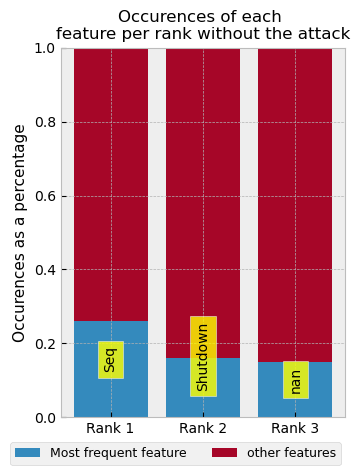

In [77]:
plt.clf()
plot_lime3(lime_one_ft2, 'without the attack'
           , save_format = 'pdf')

<Figure size 640x480 with 0 Axes>

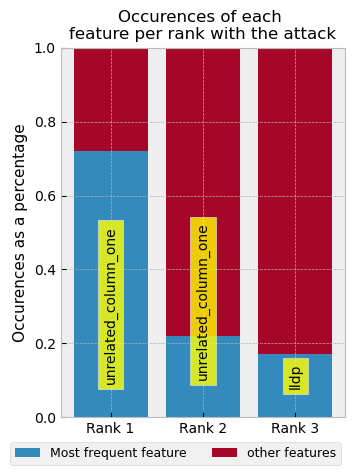

In [78]:
plt.clf()
plot_lime3(lime_one_ft, 'with the attack'
           , save_format = 'pdf')

In [ ]:
explainer2 = experiment_lime_train2(ctrl_model,
                        ce.xtest.values,
                        ce.cat_cols_ls)

lime_one_ft, Fidelity = generate_LIME_explanations(explainer,
                        adv_model,
                        ce.xtest.values[:100],
                        ce.features, True)

lime_one_ft2 = generate_LIME_explanations(explainer2,
                        ctrl_model,
                        ce.xtest.values[:100],
                        ce.features, False)

In [ ]:
explanations = []
for i in tqdm(range(ce.xtest[:10].shape[0])):
      explanations.append(explainer.explain_instance(ce.xtest.values[i], adv_model.predict_proba).as_list())
experiment_summary(explanations, ce.features)

In [ ]:
### For Debugging purposes of explanation ranking


explanations = []
for i in tqdm(range(ce.xtest[:10].shape[0])):
      explanations.append(explainer.explain_instance(ce.xtest.values[i], adv_model.predict_proba).as_list())
explanation= explanations[0]
ordered_tuples = sorted(explanation, key=lambda x : abs(x[1]), reverse=True)
print("ordered_tuples: ", ordered_tuples)
# Features without importance are renamed as 'Zero importance'
results = [re.split("[=><]+",  tup[0])[0] if tup[1] != 0 else ("Zero importance",0) for tup in ordered_tuples]

features = ce.features.to_list()
features.append("Zero importance")
for i in range(3):
      for f in features:
            # print(f)
            if f in results[i]:
                  print("yes in the features")

